#### Objective: 
We want to forecast out order volume for staffing

#### Notes :

Find the number of daily orders
Using pandasql to get used to working with SQL. 

In [3]:
!pip3 install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26821 sha256=2ff7da9a22f92a1a039f4fd8820d947bc8b6ce40a1bb92e2149c77e284f1f7d8
  Stored in directory: c:\users\daniella\appdata\local\pip\cache\wheels\ed\8f\46\a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql


You should consider upgrading via the 'c:\users\daniella\.conda\envs\py36_test\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [4]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [6]:
orders = pd.read_csv('restaurant-1-orders.csv')
orders.columns = ['number', 'timestamp', 'item', 'quantity', 'price', 'total_products_in_cart']

In [7]:
orders.sample(2)

,number,timestamp,item,quantity,price,total_products_in_cart
65728,15857,19/07/2019 17:51,Chicken Biryani,1,9.95,5
70731,3463,19/10/2016 19:12,Lamb Biryani,2,9.95,4


In [8]:
orders.head()

,number,timestamp,item,quantity,price,total_products_in_cart
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6


In [9]:
orders['date'] = pd.to_datetime(orders['timestamp'].str[:10])

In [11]:
print(f"Total number of orders in dataset: {orders['number'].nunique()}")

Total number of orders in dataset: 13397


#### Step 1 : Direct Multi-Step Forecasting 

In [12]:
def load_query(path):
    with open(path) as file:
        return file.read()

In [17]:
query=load_query('daily_orders.sql')

In [18]:
daily_orders = pysqldf(query)

In [19]:
daily_orders.sample(2)

,date,num_orders
144,2016-08-12,4
1070,2019-04-01,21


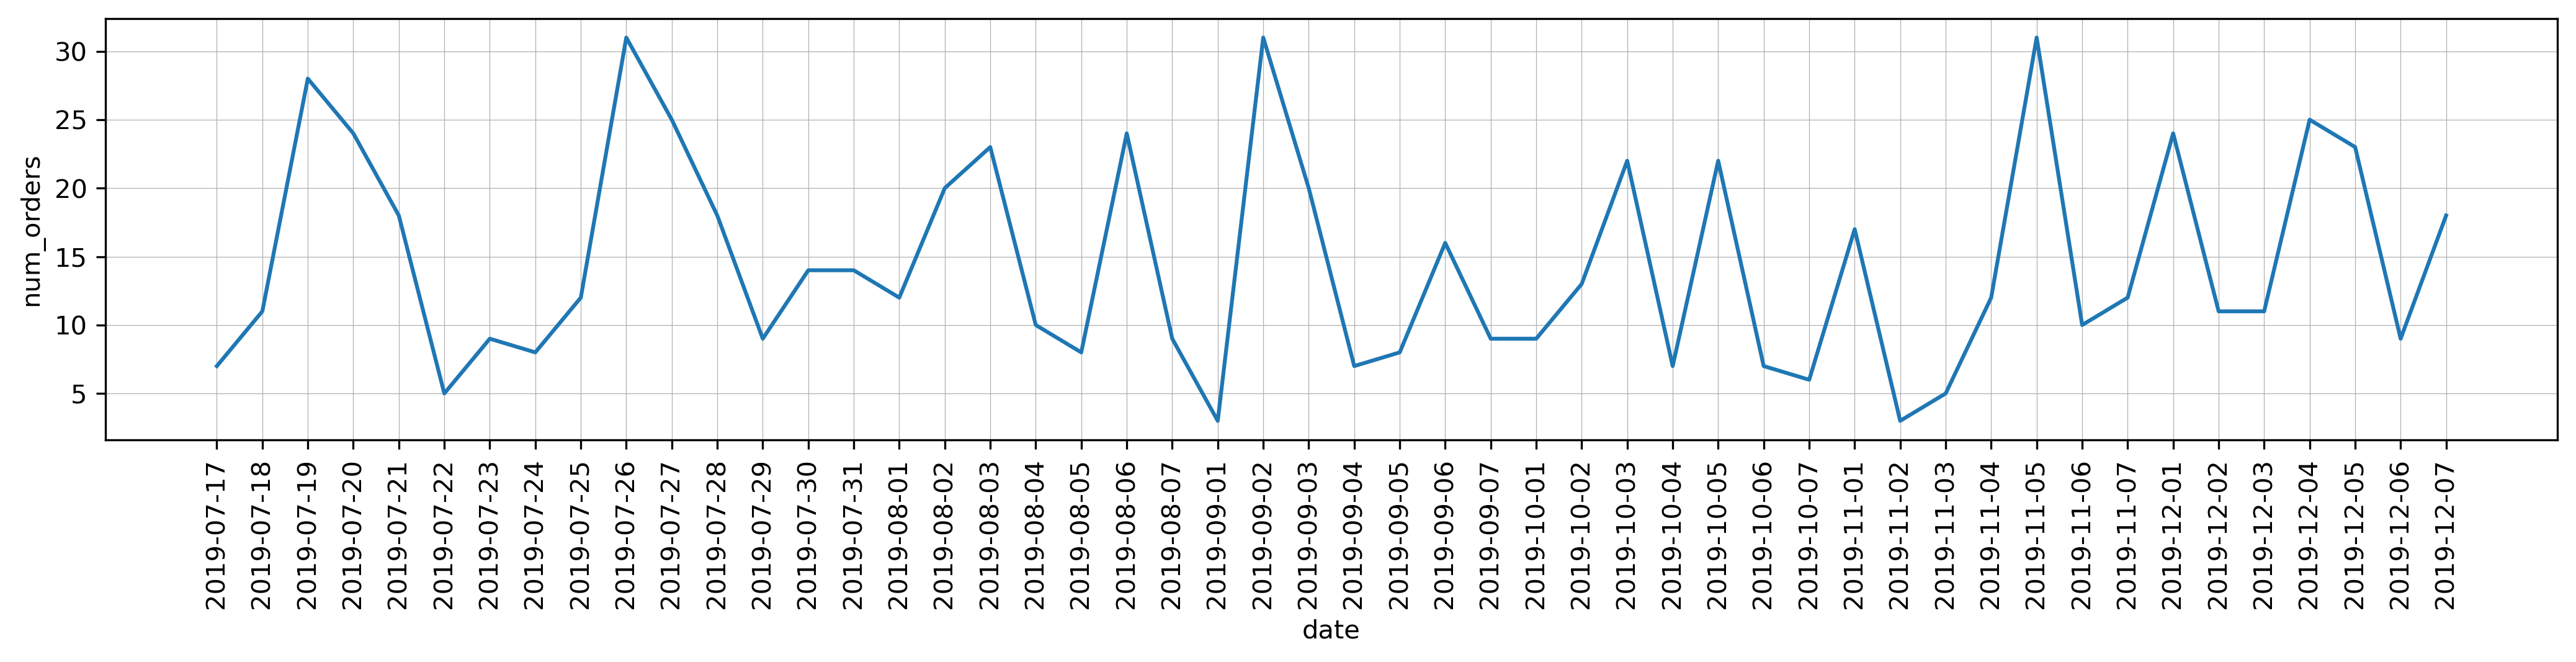

In [21]:
#PLotting the recent most 50 orders 
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=daily_orders.tail(50), x='date', y='num_orders')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

Inference-Too less orders daily to perform  forecasting. Let's look at weekly order volume instead to get a clearer idea of things .

In [22]:
# - HOW many orders in the upcoming week ? Every monday morning .

In [24]:
query = load_query('weekly_orders.sql')
weekly_orders = pysqldf(query)

In [25]:
weekly_orders.head()

,week,num_orders
0,2015-01-05,8
1,2015-02-09,5
2,2015-08-03,3
3,2015-09-07,6
4,2015-09-28,7


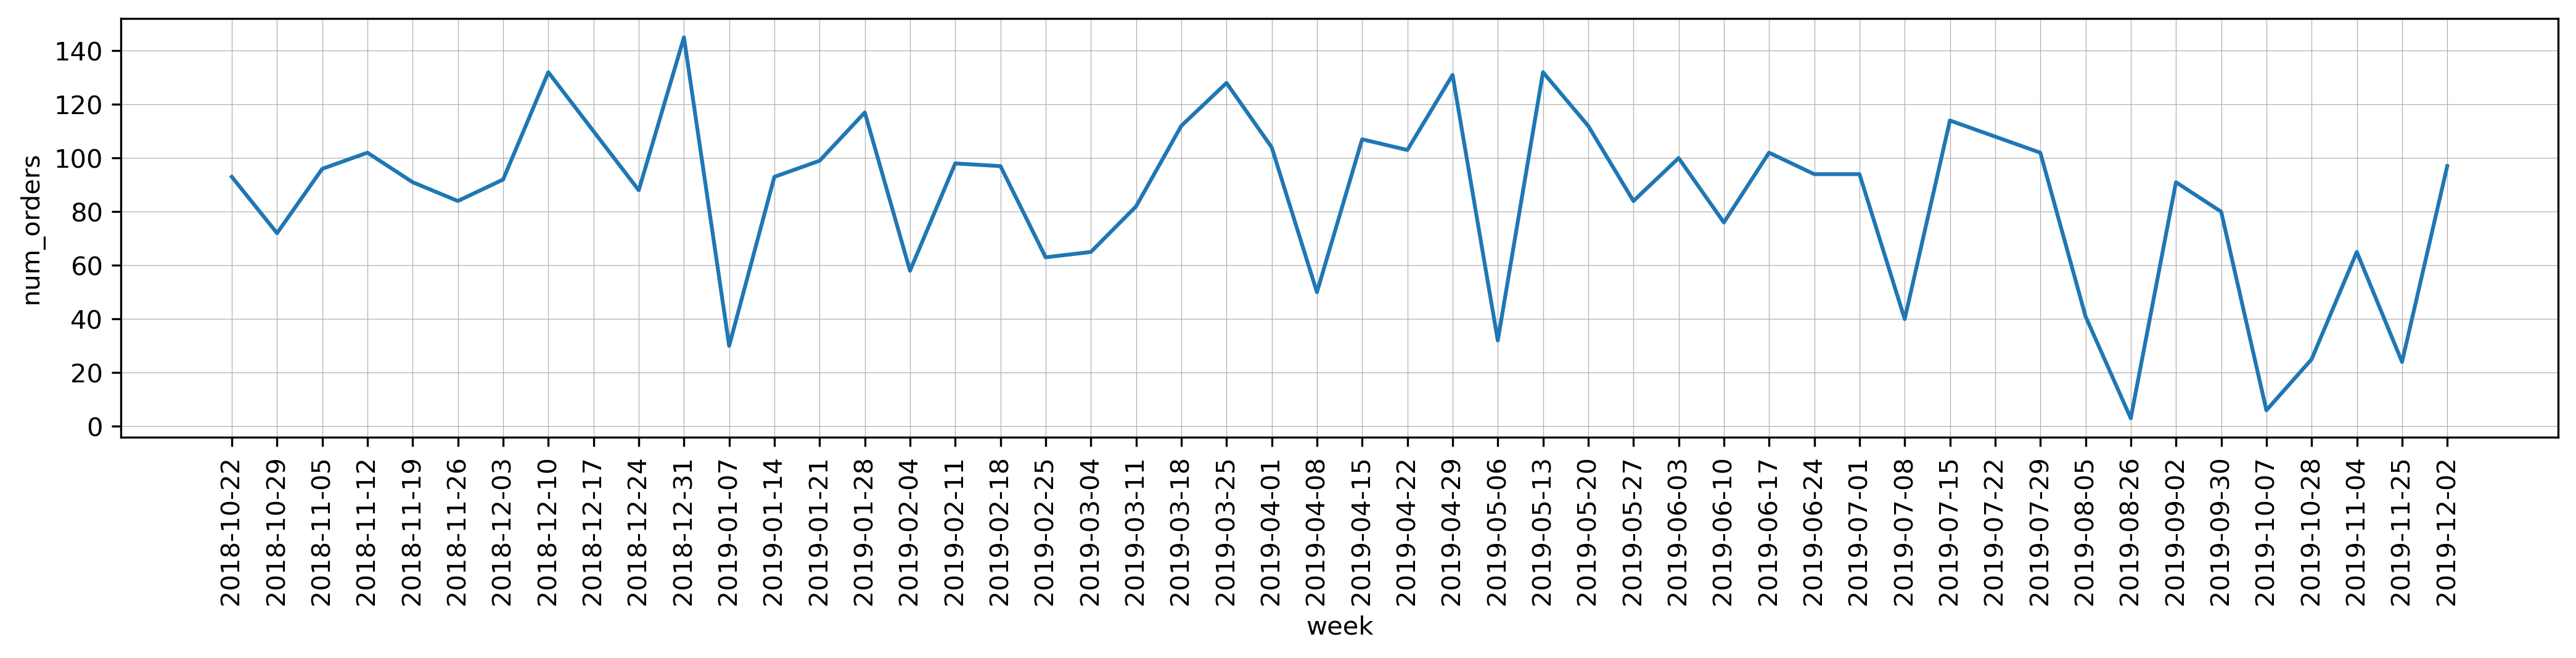

In [26]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [29]:
query = load_query('base.sql')
df = pysqldf(query)
df.to_csv('dataset.csv')

In [30]:
features = ['order_count_7_day', 'order_count_30_day']
label = 'label'
test_df = df[df['week'] >= '2019-06-01']
train_df = df[df['week'] < '2019-06-01']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [31]:
reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae')

[0]	validation_0-mae:68.79895	validation_1-mae:72.73834
[1]	validation_0-mae:68.12779	validation_1-mae:72.12849
[2]	validation_0-mae:67.46320	validation_1-mae:71.52456
[3]	validation_0-mae:66.80496	validation_1-mae:70.89914
[4]	validation_0-mae:66.15327	validation_1-mae:70.30691
[5]	validation_0-mae:65.50795	validation_1-mae:69.72041
[6]	validation_0-mae:64.86883	validation_1-mae:69.11307
[7]	validation_0-mae:64.23605	validation_1-mae:68.53793
[8]	validation_0-mae:63.60948	validation_1-mae:67.96838
[9]	validation_0-mae:62.98888	validation_1-mae:67.37858
[10]	validation_0-mae:62.37449	validation_1-mae:66.82005
[11]	validation_0-mae:61.76610	validation_1-mae:66.26697
[12]	validation_0-mae:61.16364	validation_1-mae:65.71925
[13]	validation_0-mae:60.56697	validation_1-mae:65.16515
[14]	validation_0-mae:59.97623	validation_1-mae:64.62994
[15]	validation_0-mae:59.39127	validation_1-mae:64.09995
[16]	validation_0-mae:58.81189	validation_1-mae:63.60182
[17]	validation_0-mae:58.23830	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
predictions = reg.predict(X_test)

C:\Users\Daniella\.conda\envs\py36_test\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [33]:
test_df = test_df.reset_index().drop('index', axis=1)
test_df['predictions'] = pd.Series(predictions)

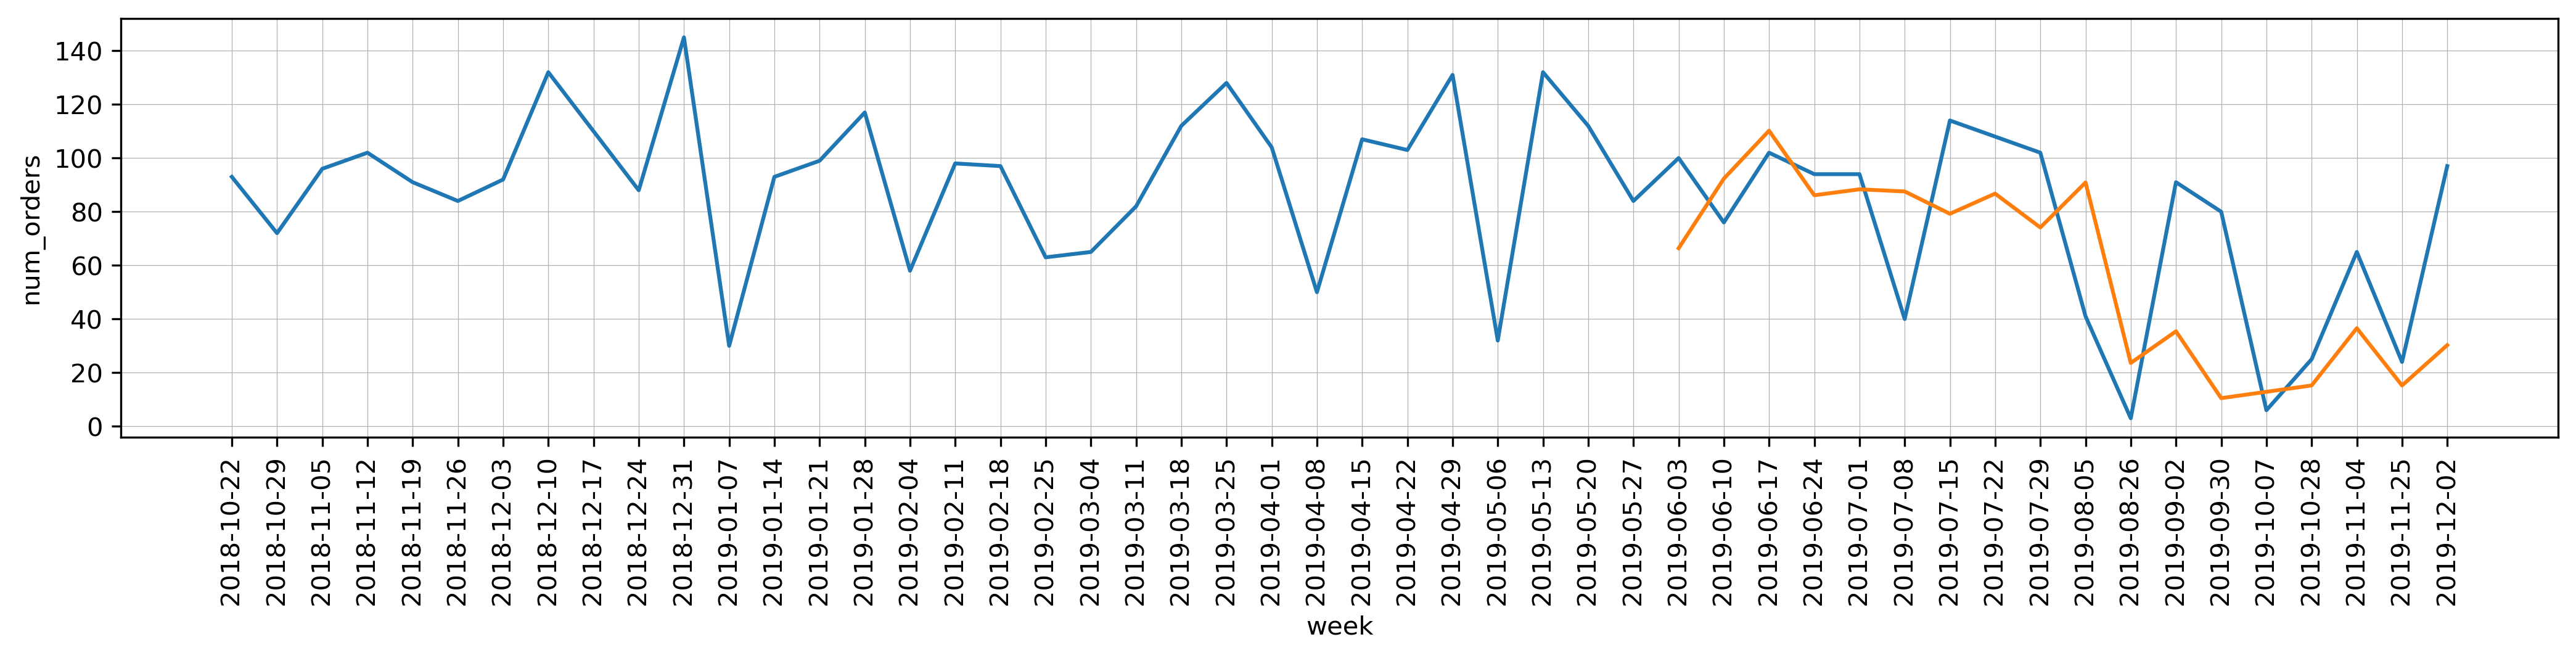

In [34]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
sns.lineplot(data=test_df, x='week', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [35]:
test_df

,week,order_count_7_day,order_count_30_day,label,predictions
0,2019-06-03,84,416,100,66.390121
1,2019-06-10,100,428,76,92.323196
2,2019-06-17,76,433,102,110.203674
3,2019-06-24,102,414,94,86.136444
4,2019-07-01,94,389,94,88.356865
5,2019-07-08,94,366,40,87.550446
6,2019-07-15,40,377,114,79.235611
7,2019-07-22,114,381,108,86.746536
8,2019-07-29,108,393,102,74.123482
9,2019-08-05,102,406,41,90.902100


#### Step 2: Prophet

In [81]:
from fbprophet import Prophet

In [82]:
data = df[['week', 'label']]
data.columns = ['ds', 'y']
train_df_prophet = data[data['ds'] < '2019-06-01']
test_df_prophet = data[data['ds'] >= '2019-06-01']

In [83]:
data = df[['week', 'label']]
data.columns = ['ds', 'y']

In [84]:
data.sample(2)

,ds,y
11,2016-04-18,44
172,2019-05-27,84


In [85]:
res = []
for idx in range(173, 190):
    train_df_prophet = data[data.index < idx]
    test_df_prophet = data[data.index == idx]
    m = Prophet(weekly_seasonality=False, daily_seasonality=False)
    m.fit(train_df_prophet)
    prophet_predictions = m.predict(test_df_prophet)
    prophet_predictions['ds'] = prophet_predictions['ds'].apply(lambda x: x.strftime('%Y-%m-%d'))
    result = test_df_prophet.merge(prophet_predictions[['ds', 'yhat']], on='ds')
    res.append(result)

In [86]:
test_df_prophet = pd.concat(res)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


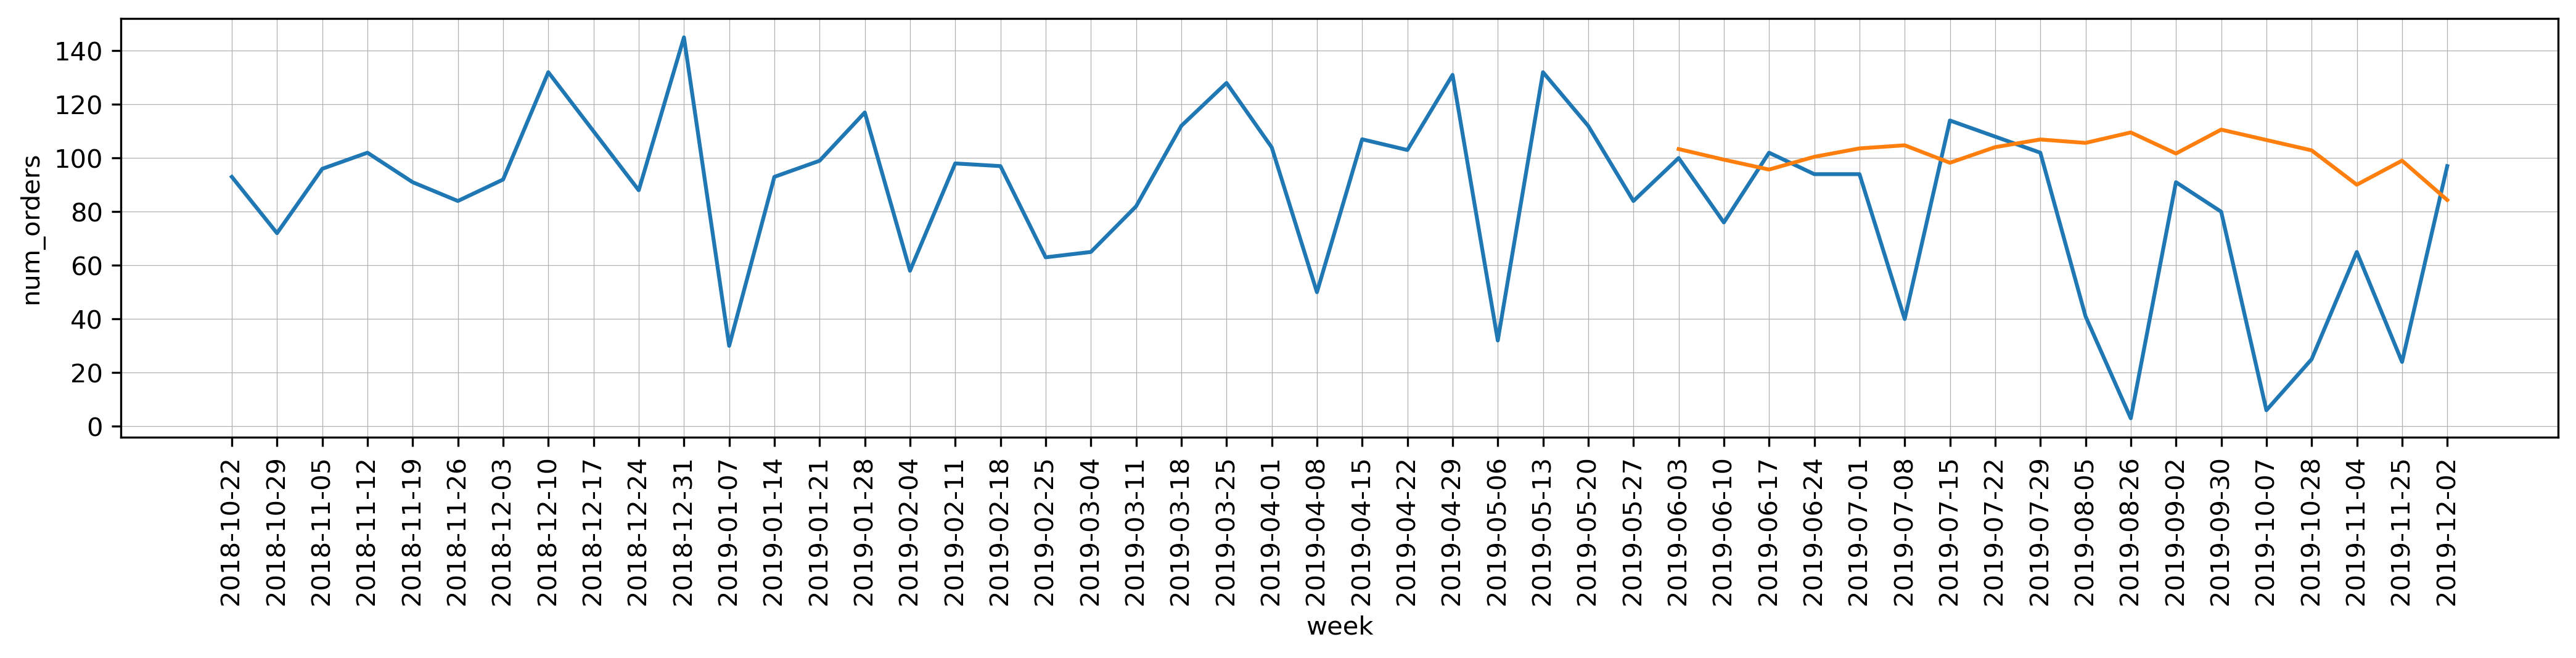

In [87]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
sns.lineplot(data=test_df_prophet, x='ds', y='yhat')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

Inference - The forecasting can be done and prediction can be made using fbprophet which performs better than . 